<a href="https://colab.research.google.com/github/rageoveralostpenny/CAPTUR/blob/main/MRCNN_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/QianyiLiu309/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 991, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 991 (delta 3), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (991/991), 136.85 MiB | 29.37 MiB/s, done.
Resolving deltas: 100% (580/580), done.


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
ROOT_DIR = os.path.abspath("Mask_RCNN")
sys.path.append(ROOT_DIR)  # To find local version of the library

from keras.utils.np_utils import to_categorical
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
%matplotlib inline

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class BikesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "bikes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 11

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1

    LEARNING_RATE = 0.01

    
config = BikesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# !ls drive/MyDrive/bike_segmentation_dataset

In [ ]:
# path = "drive/MyDrive/bike_segmentation_dataset/bicycles/"

In [ ]:
# import skimage.io
# image = skimage.io.imread(path + "0.jpeg")
# image.shape, type(image)

# plt.imshow(image)
# plt.show()

In [ ]:
label_map = {
    0: 0,
    91: 1,
    99: 2,
    127: 3,
    132: 4,
    189: 5,
    207: 6,
    211: 7,
    213: 8
  }

def align_label(input_mask):
  u, inv = np.unique(input_mask, return_inverse=True)
  input_mask = np.array([label_map[x] for x in u])[inv].reshape(input_mask.shape)
  return input_mask

In [ ]:
class BikesDataset(utils.Dataset):
  def load_bikes(self, start, count, height, width):
    total_num = 134
    dataset_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles/"
    assert start < total_num
    assert count < total_num

    self.add_class("bikes", 1, "frame")
    self.add_class("bikes", 2, "front_wheel")
    self.add_class("bikes", 3, "saddle")
    self.add_class("bikes", 4, "mudguard")
    self.add_class("bikes", 5, "back_wheel")
    self.add_class("bikes", 6, "pedals")
    self.add_class("bikes", 7, "handlebars")
    self.add_class("bikes", 8, "crank")

    self.start = start
    for i in range(count):
      # actual id in jpeg name 0-133
      # use first 95 as training, next 26 as validation 
      # start is 95 for validation and 0 for training
      index = (start + i) % total_num
      path = dataset_dir + str(index) + ".jpeg"
      # print(path)
      self.add_image(source="bikes", image_id=i, path=path)
    
    self.images_ls = []
    self.masks_ls = []
    self.class_ids_ls = []

    for i in range(count):
      self.images_ls.append(self.read_in_image(i))
      mask, class_id = self.read_in_mask(i)
      self.masks_ls.append(mask)
      self.class_ids_ls.append(class_id)

  def load_image(self, image_id):
    return self.images_ls[image_id]

  def read_in_image(self, image_id):
    # print(self.image_info[image_id]['path'])
    image = skimage.io.imread(self.image_info[image_id]['path'])
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
    # If has an alpha channel, remove it for consistency
    if image.shape[-1] == 4:
        image = image[..., :3]
    image_data = cv2.resize(image, (128, 128), interpolation=cv2.INTER_NEAREST)
    # print(image_data.shape)
    return image_data

  def load_mask(self, image_id):
    return self.masks_ls[image_id], self.class_ids_ls[image_id]

  def read_in_mask(self, image_id):
    mask_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/"
    index = (self.start + image_id) 
    mask_path = mask_dir + str(index) + ".png"
    # print(mask_path)
    input_mask = skimage.io.imread(mask_path)
    mask = align_label(input_mask)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

    u, indices = np.unique(mask, return_inverse=True)
    # u is a list of unique categories

    # due to cropping will not have all categories
    # maps from u[i] which is the actual category to a one hot encoded array (128,128,1) --> (128,128,6)
    one_hot_map = {}
    length = len(u)
    for i in range(len(u)):
      # to_categorical converts image into one hot encoded form
      one_hot_map[u[i]] = to_categorical(i, num_classes=length).astype(bool)

    # one_hot_map maps every category into a boolean array for every category in u (present in mask)
    one_hot_mask = np.array([np.array(one_hot_map[x]) for x in u])[indices].reshape((128, 128, length))
    one_hot_mask = one_hot_mask[:, :, 1:]
    # one_hot_mask a (128,128,6) boolean array and u is a list of categories (background excluded)
    return one_hot_mask, u[1:]

In [ ]:
  # original inefficient implementation of load_mask
  # def load_mask(self, image_id):
  #   # print(image_id)
  #   label_map = {
  #     0: 0,
  #     91: 1,
  #     99: 2,
  #     127: 3,
  #     132: 4,
  #     189: 5,
  #     207: 6,
  #     211: 7,
  #     213: 8
  #   }
  #   mask_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/"
  #   index = (self.start + image_id) % 134
  #   mask_path = mask_dir + str(index) + ".png"
  #   print(mask_path)
  #   input_mask = skimage.io.imread(mask_path)
  #   u, inv = np.unique(input_mask, return_inverse=True)
  #   input_mask = np.array([label_map[x] for x in u])[inv].reshape(input_mask.shape)
  #   mask = cv2.resize(input_mask, (128, 128), interpolation=cv2.INTER_NEAREST)
  #   # print(mask.shape)
  #   # print(np.amax(mask))

  #   class_ids = set()
  #   for i in range(128):
  #     for j in range(128):
  #       if mask[i][j] == 0:
  #         continue;
  #       class_ids.add(mask[i][j])
  #   class_ids = list(class_ids)
  #   mask_to_masks_map = {}

  #   for i in range(len(class_ids)):
  #     mask_to_masks_map[class_ids[i]] = i

  #   masks = np.zeros((128, 128, len(class_ids)), dtype=bool)
  #   for i in range(128):
  #     for j in range(128):
  #       if mask[i][j] == 0:
  #         continue;
  #       masks[i][j][mask_to_masks_map[mask[i][j]]] = True
  #   print(masks.shape)
  #   class_ids = np.array(class_ids).astype(np.int32) 
  #   print(class_ids)
  #   return masks, class_ids

In [ ]:
dataset_train = BikesDataset()
dataset_train.load_bikes(0, 95, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# start = 0, count = 95, width and height also included
dataset_train.prepare()

dataset_val = BikesDataset()
dataset_val.load_bikes(95, 26, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [ ]:
len(dataset_val.masks_ls), len(dataset_train.masks_ls)

(26, 95)

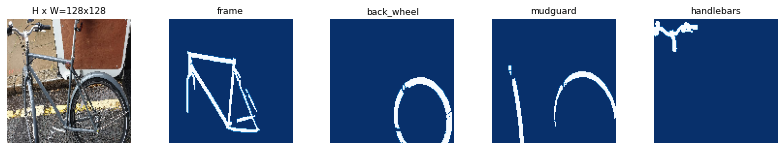

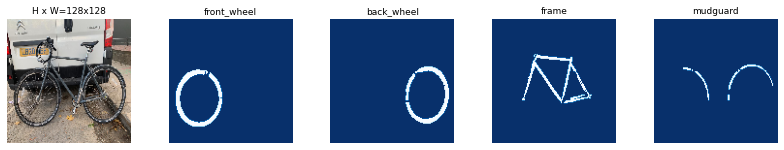

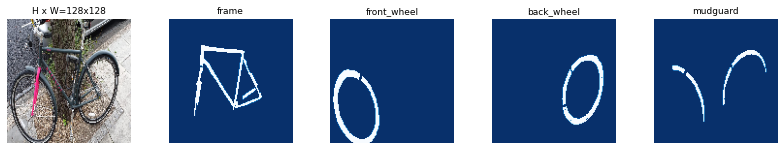

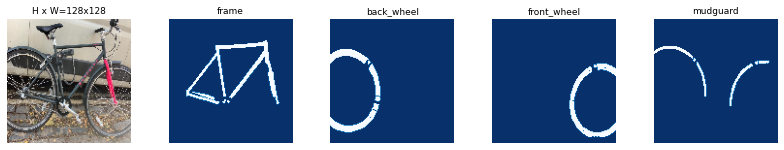

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)

for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [ ]:
# def load_bikes(self, start, count, height, width):
#   total_num = 134
#   dataset_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles/"
#   assert start < total_num

#   self.add_class("bikes", 1, "frame")
#   self.add_class("bikes", 2, "front_wheel")
#   self.add_class("bikes", 3, "saddle")
#   self.add_class("bikes", 4, "mudguard")
#   self.add_class("bikes", 5, "back_wheel")
#   self.add_class("bikes", 6, "pedals")
#   self.add_class("bikes", 7, "handlebars")
#   self.add_class("bikes", 8, "crank")

#   for i in range(count):
#     index = (start + count) % total_num
#     path = dataset_dir + str(index) + ".jpeg"
#     self.add_image(source="bikes", image_id=index, path=path)

In [ ]:
# def load_mask(self, image_id):
#   mask_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/"
#   index = (self.start + image_id) % 134
#   mask_path = mask_dir + str(index) + ".png"
#   # print(mask_path)
#   input_mask = skimage.io.imread(mask_path)
#   mask = align_label(input_mask)
#   mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

#   u, indices = np.unique(mask, return_inverse=True)
  
#   one_hot_map = {}
#   length = len(u)
#   for i in range(len(u)):
#     one_hot_map[u[i]] = to_categorical(i, num_classes=length).astype(bool)

#   one_hot_mask = np.array([np.array(one_hot_map[x]) for x in u])[indices].reshape((128, 128, length))
#   one_hot_mask = one_hot_mask[:, :, 1:]
#   return one_hot_mask, u[1:]

In [ ]:
# tmp = np.zeros((128, 128, 9), dtype=bool)
# tmp.shape

# move_background = tmp[:, :, 1:]
# move_background.shape

In [ ]:
# one_hot_map = {}

# length = len(u)
# for i in range(len(u)):
#   one_hot_map[u[i]] = to_categorical(i, num_classes=length).astype(bool)

# one_hot_map

In [ ]:
# mask_path = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/1.png"

# mask = skimage.io.imread(mask_path)
# mask = align_label(mask)
# mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

# u, indices = np.unique(mask, return_inverse=True)

# tmp = np.array([np.array(one_hot_map[x]) for x in u])[indices].reshape((128, 128, length))
# tmp.shape

# without_background = tmp[:, :, 1:]
# without_background.shape, u[1:]

In [ ]:
# from keras.utils.np_utils import to_categorical
# tmp = to_categorical(1, num_classes=7).astype(bool)
# tmp

In [ ]:
def load_mask_test(image_id):
    # print(image_id)
    label_map = {
      0: 0,
      91: 1,
      99: 2,
      127: 3,
      132: 4,
      189: 5,
      207: 6,
      211: 7,
      213: 8
    }
    mask_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/"
    index = image_id
    mask_path = mask_dir + str(index) + ".png"
    print(mask_path)
    input_mask = skimage.io.imread(mask_path)
    u, inv = np.unique(input_mask, return_inverse=True)
    input_mask = np.array([label_map[x] for x in u])[inv].reshape(input_mask.shape)
    mask = cv2.resize(input_mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    # print(mask.shape)
    # print(np.amax(mask))

    class_ids = set()
    for i in range(128):
      for j in range(128):
        if mask[i][j] == 0:
          continue;
        class_ids.add(mask[i][j])
    class_ids = list(class_ids)
    mask_to_masks_map = {}

    for i in range(len(class_ids)):
      mask_to_masks_map[class_ids[i]] = i

    masks = np.zeros((128, 128, len(class_ids)), dtype=bool)
    for i in range(128):
      for j in range(128):
        if mask[i][j] == 0:
          continue;
        masks[i][j][mask_to_masks_map[mask[i][j]]] = True
    print(masks.shape)
    class_ids = np.array(class_ids).astype(np.int32) 
    print(class_ids)
    return masks, class_ids

In [ ]:
def load_mask_test_new(image_id):
  mask_dir = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/"
  index = (0 + image_id) % 134
  mask_path = mask_dir + str(index) + ".png"
  # print(mask_path)
  input_mask = skimage.io.imread(mask_path)
  mask = align_label(input_mask)
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

  u, indices = np.unique(mask, return_inverse=True)
  
  one_hot_map = {}
  length = len(u)
  for i in range(len(u)):
    one_hot_map[u[i]] = to_categorical(i, num_classes=length).astype(bool)

  one_hot_mask = np.array([np.array(one_hot_map[x]) for x in u])[indices].reshape((128, 128, length))
  one_hot_mask = one_hot_mask[:, :, 1:]
  return one_hot_mask, u[1:]

In [ ]:
masks_1, class_ids_1 = load_mask_test(1)
masks_2, class_ids_2 = load_mask_test_new(1)

np.amin(np.array(masks_1 == masks_2)), np.amin(np.array(class_ids_1 == class_ids_2))

drive/MyDrive/bike_segmentation_dataset/bicycles_labels/1.png
(128, 128, 6)
[1 2 3 4 5 7]


(True, True)

In [ ]:
# masks, class_ids = load_mask_test()

In [ ]:
# np.amin(masks==without_background)

In [ ]:
# mask_path = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/1.png"

# mask = load_mask(mask_path)
# mask.shape

# instance_num = np.amax(mask)
# instance_num

# masks = np.zeros((128, 128, instance_num), dtype=bool)

# class_ids = set()

# for i in range(128):
#   for j in range(128):
#     if mask[i][j] == 0:
#       continue;
#     class_ids.add(mask[i][j])

# class_ids = list(class_ids)

# mask_to_masks_map = {}

# for i in range(len(class_ids)):
#   mask_to_masks_map[class_ids[i]] = i

# mask_to_masks_map

# for i in range(128):
#   for j in range(128):
#     if mask[i][j] == 0:
#       continue;
#     masks[i][j][mask_to_masks_map[mask[i][j]]] = True

# def load_mask(self, image_id):
#   mask_path = self.image_info[image_id]['path']
#   mask = load_mask(mask_path)

#   masks = np.zeros((128, 128, instance_num), dtype=bool)

#   class_ids = set()

#   for i in range(128):
#     for j in range(128):
#       if mask[i][j] == 0:
#         continue;
#       class_ids.add(mask[i][j])

#   class_ids = list(class_ids)
#   mask_to_masks_map = {}

#   for i in range(len(class_ids)):
#     mask_to_masks_map[class_ids[i]] = i

#   for i in range(128):
#     for j in range(128):
#       if mask[i][j] == 0:
#         continue;
#       masks[i][j][mask_to_masks_map[mask[i][j]]] = True

#   return masks

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def read_in_image_single():
    image = skimage.io.imread("drive/MyDrive/bike_segmentation_dataset/bicycles/95.jpeg")
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
    # If has an alpha channel, remove it for consistency
    if image.shape[-1] == 4:
        image = image[..., :3]
    image_data = cv2.resize(image, (128, 128), interpolation=cv2.INTER_NEAREST)
    # print(image_data.shape)
    return image_data


def read_in_mask_single():
  mask_path = "drive/MyDrive/bike_segmentation_dataset/bicycles_labels/95.png"
  input_mask = skimage.io.imread(mask_path)
  mask = align_label(input_mask)
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
  mask = np.expand_dims(mask, -1)
  return mask

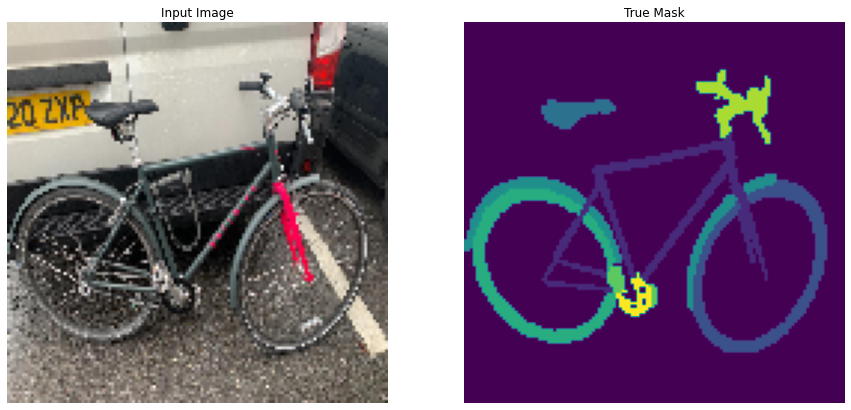

In [ ]:
sample_image = read_in_image_single()
sample_mask = read_in_mask_single()

display([sample_image, sample_mask])

In [ ]:
!rm -rf Mask_RCNN/logs/
# removing original logs between training runs

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
   #imagenet: dataset for image classification
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     min_delta=0, 
#     patience=20, 
#     verbose=1, 
#     mode='min', 
#     restore_best_weights=True
# )

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.01

Checkpoint Path: /content/Mask_RCNN/logs/bikes20211006T1500/mask_rcnn_bikes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Tim

In [ ]:
class InferenceConfig(BikesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

original_image.shape

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
saved_path = "drive/MyDrive/saved_model/mrcnn_100"
model.save(saved_path)